# Linear Programming Review and Multi-Objective Optimization

This notebook reviews the fundamentals of Linear Programming (LP) and introduces Multi-Objective Decision Making (MODM) concepts.

## Learning Objectives

1. Review Linear Programming fundamentals
2. Understand single-objective optimization
3. Recognize limitations of single-objective approaches
4. Introduction to Multi-Objective Decision Making
5. Compare single vs. multi-objective optimization

## Part 1: Linear Programming Review

### What is Linear Programming?

Linear Programming is a mathematical method for determining optimal resource allocation. It involves:

- **Objective function**: A linear function to maximize or minimize
- **Decision variables**: Variables we can control
- **Constraints**: Linear inequalities or equalities that limit our choices
- **Non-negativity**: Decision variables are typically non-negative

### Standard Form

Maximize (or Minimize): $Z = c_1x_1 + c_2x_2 + ... + c_nx_n$

Subject to:
$$
\begin{align}
a_{11}x_1 + a_{12}x_2 + ... + a_{1n}x_n &\leq b_1 \\
a_{21}x_1 + a_{22}x_2 + ... + a_{2n}x_n &\leq b_2 \\
&\vdots \\
a_{m1}x_1 + a_{m2}x_2 + ... + a_{mn}x_n &\leq b_m \\
x_1, x_2, ..., x_n &\geq 0
\end{align}
$$

## Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
import pandas as pd

np.random.seed(42)

## Example 1: Classic Production Planning Problem

A company produces two products: A and B.

- Product A: Profit = $40 per unit
- Product B: Profit = $30 per unit

**Constraints:**
- Labor: Product A requires 2 hours, Product B requires 1 hour (Total: 100 hours available)
- Material: Product A requires 1 kg, Product B requires 1 kg (Total: 80 kg available)
- Product A cannot exceed 40 units (market constraint)

**Formulation:**

Maximize: $Z = 40x_1 + 30x_2$

Subject to:
$$
\begin{align}
2x_1 + x_2 &\leq 100 \quad \text{(Labor)} \\
x_1 + x_2 &\leq 80 \quad \text{(Material)} \\
x_1 &\leq 40 \quad \text{(Market)} \\
x_1, x_2 &\geq 0
\end{align}
$$

### Graphical Solution

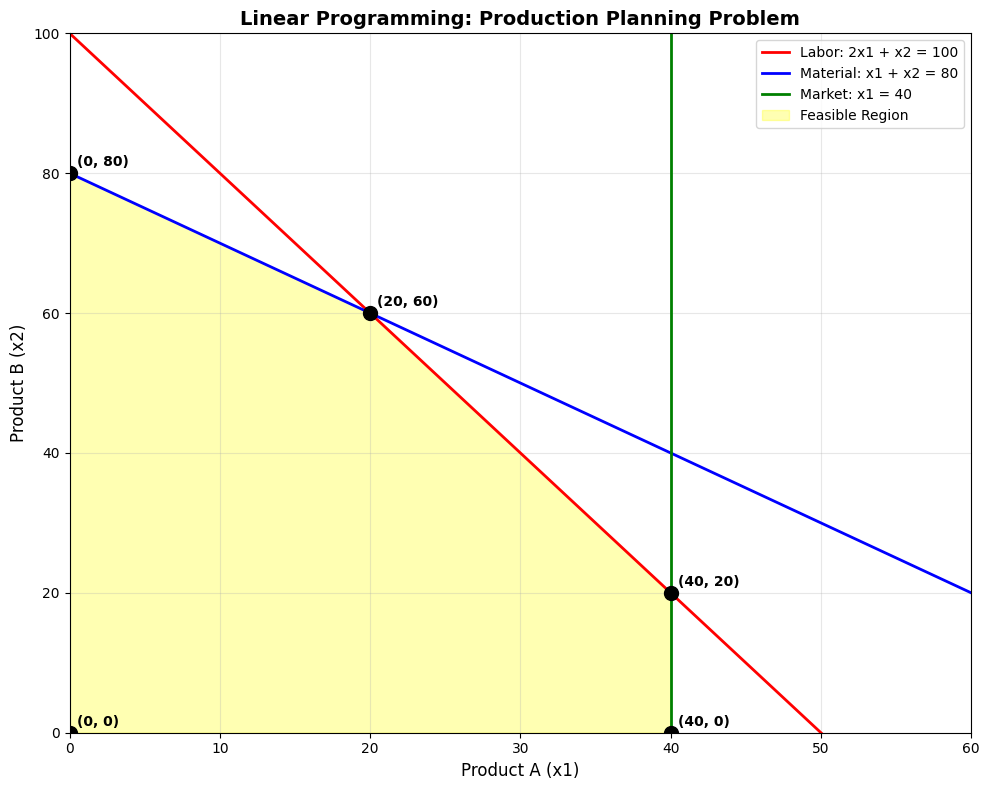

In [2]:
def plot_lp_problem():
    fig, ax = plt.subplots(figsize=(10, 8))

    x1 = np.linspace(0, 60, 300)

    # Constraint lines
    labor = 100 - 2 * x1  # 2x1 + x2 <= 100
    material = 80 - x1  # x1 + x2 <= 80
    market = np.full_like(x1, 40)  # x1 <= 40

    ax.plot(x1, labor, "r-", label="Labor: 2x1 + x2 = 100", linewidth=2)
    ax.plot(x1, material, "b-", label="Material: x1 + x2 = 80", linewidth=2)
    ax.axvline(
        x=40, color="g", linestyle="-", label="Market: x1 = 40", linewidth=2
    )

    # Feasible region
    x1_fill = np.linspace(0, 40, 300)
    labor_fill = 100 - 2 * x1_fill
    material_fill = 80 - x1_fill

    y_lower = np.maximum(0, np.minimum(labor_fill, material_fill))
    ax.fill_between(
        x1_fill, 0, y_lower, alpha=0.3, color="yellow", label="Feasible Region"
    )

    # Corner points
    corners = [(0, 0), (0, 80), (20, 60), (40, 20), (40, 0)]
    for i, (x, y) in enumerate(corners):
        ax.plot(x, y, "ko", markersize=10)
        ax.annotate(
            f"({x}, {y})",
            xy=(x, y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xlim(0, 60)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Product A (x1)", fontsize=12)
    ax.set_ylabel("Product B (x2)", fontsize=12)
    ax.set_title(
        "Linear Programming: Production Planning Problem",
        fontsize=14,
        fontweight="bold",
    )
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig


plot_lp_problem()
plt.show()

The feasible region is the yellow area. The optimal solution must be at one of the corner points.

### Evaluate Corner Points

In [3]:
def evaluate_corner_points():
    corners = [(0, 0), (0, 80), (20, 60), (40, 20), (40, 0)]

    results = []
    for x1, x2 in corners:
        profit = 40 * x1 + 30 * x2
        results.append(
            {
                "Product A (x1)": x1,
                "Product B (x2)": x2,
                "Total Profit ($)": profit,
            }
        )

    df = pd.DataFrame(results)
    return df


corner_results = evaluate_corner_points()
print(corner_results)
print(
    f"\nOptimal Solution: {corner_results.loc[corner_results['Total Profit ($)'].idxmax()].to_dict()}"
)

   Product A (x1)  Product B (x2)  Total Profit ($)
0               0               0                 0
1               0              80              2400
2              20              60              2600
3              40              20              2200
4              40               0              1600

Optimal Solution: {'Product A (x1)': 20, 'Product B (x2)': 60, 'Total Profit ($)': 2600}


The optimal solution is to produce 20 units of Product A and 60 units of Product B for a maximum profit of $2,600.

### Solving with scipy.optimize.linprog

In [4]:
# Note: linprog minimizes by default, so we negate the objective coefficients
c = [-40, -30]  # Negative because we want to maximize

# Inequality constraints (A_ub @ x <= b_ub)
A_ub = [
    [2, 1],  # Labor constraint
    [1, 1],  # Material constraint
    [1, 0],  # Market constraint
]
b_ub = [100, 80, 40]

# Bounds for variables (x1 >= 0, x2 >= 0)
bounds = [(0, None), (0, None)]

# Solve
result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

print("Optimization Result:")
print(f"Status: {result.message}")
print(f"Optimal Product A: {result.x[0]:.2f} units")
print(f"Optimal Product B: {result.x[1]:.2f} units")
print(f"Maximum Profit: ${-result.fun:.2f}")

Optimization Result:
Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal Product A: 20.00 units
Optimal Product B: 60.00 units
Maximum Profit: $2600.00


## Example 2: Diet Problem

A classic LP problem where we want to minimize cost while meeting nutritional requirements.

Two foods: Bread and Milk

| Food | Cost ($/unit) | Protein (g) | Carbs (g) | Fat (g) |
|------|---------------|-------------|-----------|----------|
| Bread | 2 | 4 | 15 | 2 |
| Milk | 3 | 8 | 12 | 5 |

**Requirements:**
- At least 40g protein
- At least 80g carbs
- At least 20g fat

**Formulation:**

Minimize: $Z = 2x_1 + 3x_2$

Subject to:
$$
\begin{align}
4x_1 + 8x_2 &\geq 40 \quad \text{(Protein)} \\
15x_1 + 12x_2 &\geq 80 \quad \text{(Carbs)} \\
2x_1 + 5x_2 &\geq 20 \quad \text{(Fat)} \\
x_1, x_2 &\geq 0
\end{align}
$$

In [5]:
# Objective: minimize cost
c = [2, 3]

# Constraints (convert >= to <= by multiplying by -1)
A_ub = [
    [-4, -8],  # Protein: 4x1 + 8x2 >= 40
    [-15, -12],  # Carbs: 15x1 + 12x2 >= 80
    [-2, -5],  # Fat: 2x1 + 5x2 >= 20
]
b_ub = [-40, -80, -20]

bounds = [(0, None), (0, None)]

result = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")

print("Diet Problem Solution:")
print(f"Status: {result.message}")
print(f"Optimal Bread units: {result.x[0]:.2f}")
print(f"Optimal Milk units: {result.x[1]:.2f}")
print(f"Minimum Cost: ${result.fun:.2f}")

# Verify constraints
protein = 4 * result.x[0] + 8 * result.x[1]
carbs = 15 * result.x[0] + 12 * result.x[1]
fat = 2 * result.x[0] + 5 * result.x[1]

print(f"\nNutrition achieved:")
print(f"Protein: {protein:.2f}g (required: >= 40g)")
print(f"Carbs: {carbs:.2f}g (required: >= 80g)")
print(f"Fat: {fat:.2f}g (required: >= 20g)")

Diet Problem Solution:
Status: Optimization terminated successfully. (HiGHS Status 7: Optimal)
Optimal Bread units: 2.22
Optimal Milk units: 3.89
Minimum Cost: $16.11

Nutrition achieved:
Protein: 40.00g (required: >= 40g)
Carbs: 80.00g (required: >= 80g)
Fat: 23.89g (required: >= 20g)


## Limitations of Single-Objective Linear Programming

### The Real-World Challenge

In the production problem, we maximized profit. But what if the company also cares about:
- Minimizing waste
- Maximizing employee satisfaction
- Reducing environmental impact
- Maintaining product diversity

**Problem**: These objectives often conflict with each other.

- Maximizing profit might require longer work hours (lower satisfaction)
- Minimizing cost might increase environmental impact
- Reducing waste might decrease profit margins

### Single-Objective Approaches to Multiple Objectives

1. **Weighted Sum**: Combine objectives into one
2. **Constraint Method**: Optimize one objective while constraining others
3. **Sequential Optimization**: Optimize objectives in priority order

**Limitations**:
- Difficult to determine appropriate weights
- May miss superior trade-off solutions
- Sensitive to scaling of objectives

## Part 2: Introduction to Multi-Objective Decision Making

### What is Multi-Objective Optimization?

Multi-Objective Optimization deals with problems involving multiple, often conflicting objectives simultaneously.

**General Form:**

Optimize: $\mathbf{F}(\mathbf{x}) = [f_1(\mathbf{x}), f_2(\mathbf{x}), ..., f_k(\mathbf{x})]$

Subject to:
$$
\begin{align}
g_i(\mathbf{x}) &\leq 0, \quad i = 1, ..., m \\
h_j(\mathbf{x}) &= 0, \quad j = 1, ..., p \\
\mathbf{x} &\in X
\end{align}
$$

Where:
- $\mathbf{x}$ is the decision vector
- $f_i$ are the objective functions
- $g_i$ are inequality constraints
- $h_j$ are equality constraints
- $X$ is the feasible region

### Key Concepts

#### 1. Pareto Optimality (Pareto Efficiency)

A solution is Pareto optimal if no objective can be improved without degrading at least one other objective.

**Dominance**: Solution A dominates solution B if:
- A is at least as good as B in all objectives
- A is strictly better than B in at least one objective

#### 2. Pareto Front (Pareto Frontier)

The set of all Pareto optimal solutions forms the Pareto front.

#### 3. Trade-offs

Moving along the Pareto front requires trading off one objective for another.

## Example 3: Bi-Objective Production Problem

Extend our production problem to consider two objectives:

1. **Maximize Profit**: $f_1(x_1, x_2) = 40x_1 + 30x_2$
2. **Minimize Production Time**: $f_2(x_1, x_2) = 3x_1 + 2x_2$

Subject to the same constraints as before.

In [6]:
def is_feasible(x1, x2):
    """Check if a solution satisfies all constraints."""
    if x1 < 0 or x2 < 0:
        return False
    if 2 * x1 + x2 > 100:  # Labor
        return False
    if x1 + x2 > 80:  # Material
        return False
    if x1 > 40:  # Market
        return False
    return True


def calculate_objectives(x1, x2):
    """Calculate profit and production time."""
    profit = 40 * x1 + 30 * x2
    time = 3 * x1 + 2 * x2
    return profit, time


# Generate candidate solutions (corner points and others)
candidates = [(0, 0), (0, 80), (20, 60), (40, 20), (40, 0), (10, 70), (30, 40)]

results = []
for x1, x2 in candidates:
    if is_feasible(x1, x2):
        profit, time = calculate_objectives(x1, x2)
        results.append(
            {"x1": x1, "x2": x2, "Profit ($)": profit, "Time (hrs)": time}
        )

df_multi = pd.DataFrame(results)
print(df_multi)

   x1  x2  Profit ($)  Time (hrs)
0   0   0           0           0
1   0  80        2400         160
2  20  60        2600         180
3  40  20        2200         160
4  40   0        1600         120
5  10  70        2500         170
6  30  40        2400         170


### Visualize the Trade-off

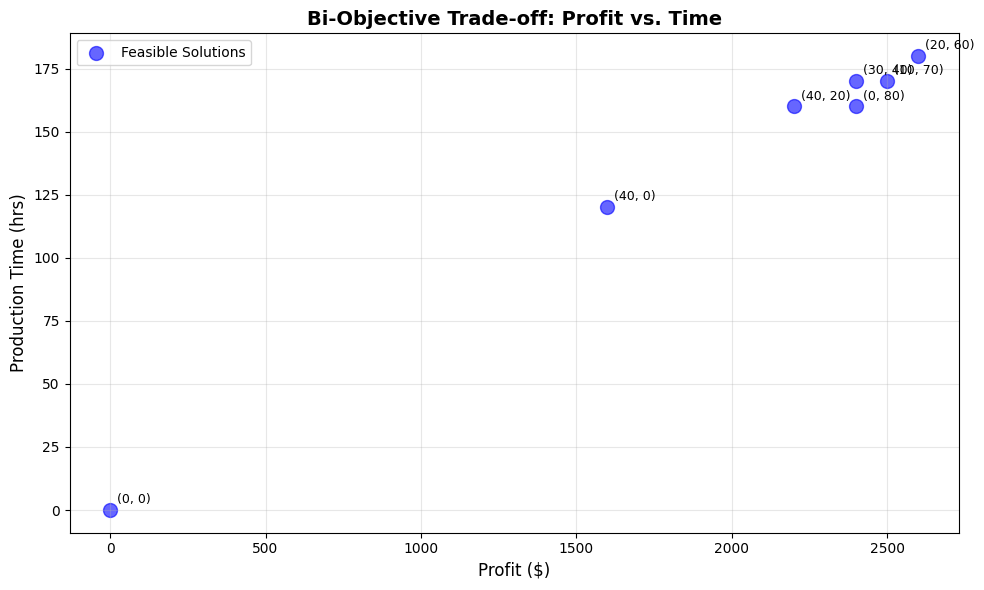

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot all feasible solutions
ax.scatter(
    df_multi["Profit ($)"],
    df_multi["Time (hrs)"],
    s=100,
    c="blue",
    alpha=0.6,
    label="Feasible Solutions",
)

# Annotate points
for _, row in df_multi.iterrows():
    ax.annotate(
        f"({row['x1']}, {row['x2']})",
        xy=(row["Profit ($)"], row["Time (hrs)"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )

ax.set_xlabel("Profit ($)", fontsize=12)
ax.set_ylabel("Production Time (hrs)", fontsize=12)
ax.set_title(
    "Bi-Objective Trade-off: Profit vs. Time", fontsize=14, fontweight="bold"
)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

### Identify Pareto Optimal Solutions

In [8]:
def is_dominated(solution, all_solutions):
    """Check if a solution is dominated by any other solution.

    For maximizing profit and minimizing time:
    Solution A dominates B if profit_A >= profit_B AND time_A <= time_B
    with at least one strict inequality.
    """
    profit_s, time_s = solution["Profit ($)"], solution["Time (hrs)"]

    for _, other in all_solutions.iterrows():
        profit_o, time_o = other["Profit ($)"], other["Time (hrs)"]

        # Check if other dominates solution
        if (
            profit_o >= profit_s
            and time_o <= time_s
            and (profit_o > profit_s or time_o < time_s)
        ):
            return True

    return False


# Find Pareto optimal solutions
pareto_optimal = []
for idx, sol in df_multi.iterrows():
    if not is_dominated(sol, df_multi):
        pareto_optimal.append(idx)

df_multi["Pareto Optimal"] = False
df_multi.loc[pareto_optimal, "Pareto Optimal"] = True

print("All Solutions:")
print(df_multi)
print(f"\nPareto Optimal Solutions:")
print(df_multi[df_multi["Pareto Optimal"]])

All Solutions:
   x1  x2  Profit ($)  Time (hrs)  Pareto Optimal
0   0   0           0           0            True
1   0  80        2400         160            True
2  20  60        2600         180            True
3  40  20        2200         160           False
4  40   0        1600         120            True
5  10  70        2500         170            True
6  30  40        2400         170           False

Pareto Optimal Solutions:
   x1  x2  Profit ($)  Time (hrs)  Pareto Optimal
0   0   0           0           0            True
1   0  80        2400         160            True
2  20  60        2600         180            True
4  40   0        1600         120            True
5  10  70        2500         170            True


### Visualize Pareto Front

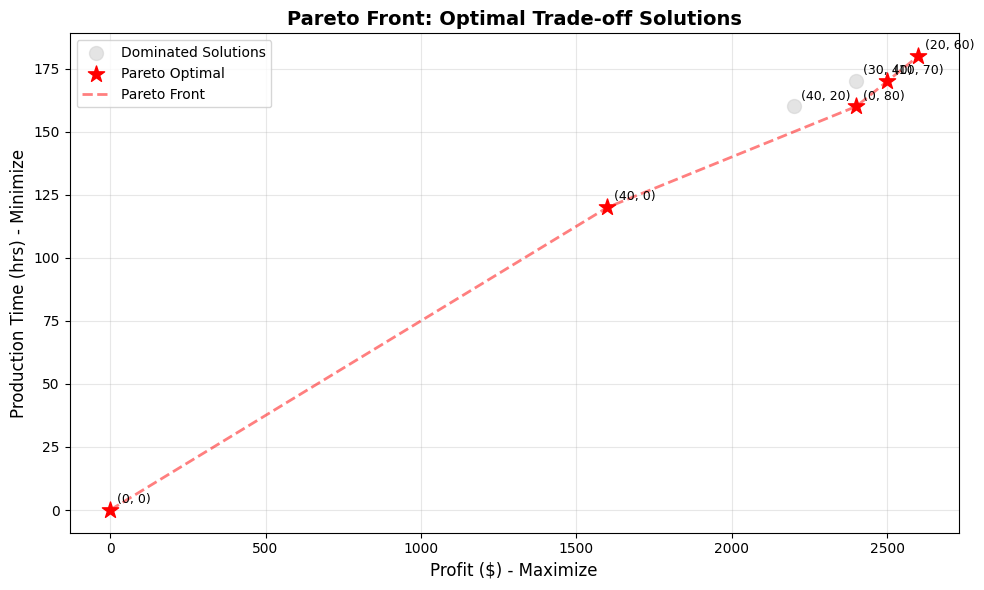

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

# Dominated solutions
dominated = df_multi[~df_multi["Pareto Optimal"]]
ax.scatter(
    dominated["Profit ($)"],
    dominated["Time (hrs)"],
    s=100,
    c="lightgray",
    alpha=0.6,
    label="Dominated Solutions",
)

# Pareto optimal solutions
pareto = df_multi[df_multi["Pareto Optimal"]].sort_values("Profit ($)")
ax.scatter(
    pareto["Profit ($)"],
    pareto["Time (hrs)"],
    s=150,
    c="red",
    marker="*",
    label="Pareto Optimal",
    zorder=5,
)

# Connect Pareto points
ax.plot(
    pareto["Profit ($)"],
    pareto["Time (hrs)"],
    "r--",
    linewidth=2,
    alpha=0.5,
    label="Pareto Front",
)

# Annotate all points
for _, row in df_multi.iterrows():
    ax.annotate(
        f"({row['x1']}, {row['x2']})",
        xy=(row["Profit ($)"], row["Time (hrs)"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=9,
    )

ax.set_xlabel("Profit ($) - Maximize", fontsize=12)
ax.set_ylabel("Production Time (hrs) - Minimize", fontsize=12)
ax.set_title(
    "Pareto Front: Optimal Trade-off Solutions", fontsize=14, fontweight="bold"
)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

The red stars show Pareto optimal solutions. Moving along the Pareto front means trading profit for time or vice versa.

## Comparison: Single vs. Multi-Objective Optimization

| Aspect | Single-Objective | Multi-Objective |
|--------|------------------|------------------|
| **Goal** | Find one optimal solution | Find set of optimal trade-offs |
| **Solution** | Unique optimal point | Pareto front (multiple solutions) |
| **Decision Making** | Automatic | Requires decision maker input |
| **Complexity** | Lower | Higher |
| **Flexibility** | Limited | High |
| **Real-world applicability** | Often oversimplified | More realistic |
| **Computational cost** | Lower | Higher |

## When to Use Multi-Objective Optimization

Use MODM when:

1. **Multiple conflicting objectives** exist naturally in the problem
2. **Trade-offs** need to be explored and understood
3. **Decision maker preferences** are not known a priori
4. **Flexibility** in final solution selection is desired
5. **Robust solutions** are needed across different scenarios

Examples:
- Portfolio optimization (return vs. risk)
- Engineering design (cost vs. performance vs. safety)
- Supply chain (cost vs. delivery time vs. sustainability)
- Resource allocation (efficiency vs. equity vs. environmental impact)

## Summary

### Linear Programming Review
- Optimize a single linear objective function
- Subject to linear constraints
- Optimal solution at corner points of feasible region
- Well-developed theory and efficient algorithms

### Multi-Objective Decision Making
- Handles multiple, often conflicting objectives
- Results in a set of Pareto optimal solutions
- Requires decision maker involvement to select final solution
- More realistic for complex real-world problems

### Key Takeaway
Multi-objective optimization does not seek to find THE optimal solution, but rather A SET of optimal solutions (Pareto front) that represent different trade-offs between objectives. The final choice depends on decision maker preferences and context.

## Next Steps

In upcoming lectures, we will explore:

1. **Pareto Optimization**: Algorithms to find the Pareto front
2. **Goal Programming**: Achieve satisfactory levels for multiple objectives